# **Classification and Localisation of Oxford IIIT PET Dataset**

More info of dataset can be found -: https://www.robots.ox.ac.uk/~vgg/data/pets/

## **----------------------------Classification---------------------------------**

### **Importing all Libraries**


In [ ]:
from keras.applications.resnet50 import ResNet50
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense

from keras import models
from keras import layers
from keras import optimizers
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications import EfficientNetB7

import numpy as np
import os, shutil
import cv2
import matplotlib.pyplot as plt

In [7]:
## Using dataset from kaggle directly 

## Uploading the json file
!pip install -q kaggle
from google.colab import files
files.upload()

#  ! kaggle datasets list

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"ridhimagarg","key":"2d80d33488989d29e7e131658cd68c80"}'}

In [8]:
## Changing the mode of json file uploaded

!mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

### **Download and extract the dataset into folder data**

In [9]:
!kaggle datasets download -d tanlikesmath/the-oxfordiiit-pet-dataset
! unzip the-oxfordiiit-pet-dataset.zip -d data

Streaming output truncated to the last 5000 lines.
  inflating: data/images/images/leonberger_81.jpg  
  inflating: data/images/images/leonberger_82.jpg  
  inflating: data/images/images/leonberger_83.jpg  
  inflating: data/images/images/leonberger_84.jpg  
  inflating: data/images/images/leonberger_85.jpg  
  inflating: data/images/images/leonberger_86.jpg  
  inflating: data/images/images/leonberger_87.jpg  
  inflating: data/images/images/leonberger_88.jpg  
  inflating: data/images/images/leonberger_89.jpg  
  inflating: data/images/images/leonberger_9.jpg  
  inflating: data/images/images/leonberger_90.jpg  
  inflating: data/images/images/leonberger_91.jpg  
  inflating: data/images/images/leonberger_92.jpg  
  inflating: data/images/images/leonberger_93.jpg  
  inflating: data/images/images/leonberger_94.jpg  
  inflating: data/images/images/leonberger_95.jpg  
  inflating: data/images/images/leonberger_96.jpg  
  inflating: data/images/images/leonberger_97.jpg  
  inflating: d

### **Making directories for train, test, validation**

In [ ]:
base_dir = ''
original_dataset_dir = 'data/images/'

In [ ]:
train_dir = os.path.join(base_dir, 'train')
if not os.path.exists(train_dir):
  os.mkdir(train_dir)
else:
  print("Already existed!")

validation_dir = os.path.join(base_dir, 'validation')
if not os.path.exists(validation_dir):
  os.mkdir(validation_dir)
else:
  print("Already existed!")

test_dir = os.path.join(base_dir, 'test')
if not os.path.exists(test_dir):
  os.mkdir(test_dir)
else:
  print("Already existed!")

In [ ]:
## Checking the classes list

class_li = []
for file in os.listdir(original_dataset_dir):
    if file.split(".")[0].rsplit("_",1)[0] not in class_li:
        class_li.append(file.split(".")[0].rsplit("_",1)[0])
print(class_li)

['boxer', 'Russian_Blue', 'Bengal', 'american_pit_bull_terrier', 'english_cocker_spaniel', 'samoyed', 'keeshond', 'chihuahua', 'basset_hound', 'pug', 'Birman', 'Persian', 'Egyptian_Mau', 'British_Shorthair', 'american_bulldog', 'leonberger', 'Siamese', 'Sphynx', 'great_pyrenees', 'beagle', 'Bombay', 'japanese_chin', 'staffordshire_bull_terrier', 'miniature_pinscher', 'saint_bernard', 'english_setter', 'wheaten_terrier', 'Abyssinian', 'shiba_inu', 'Maine_Coon', 'Ragdoll', 'yorkshire_terrier', 'scottish_terrier', 'german_shorthaired', 'newfoundland', 'pomeranian', 'havanese', 'images']


### **Copying the data to train, test, validation**

In [ ]:
for cl in class_li:
    os.mkdir(os.path.join(train_dir, cl))
    fnames = ['{}_{}.jpg'.format(cl, i) for i in range(1, 100)]
    for fname in fnames:
        src = os.path.join(original_dataset_dir, fname)
        dst = os.path.join(os.path.join(train_dir, cl), fname)
        if os.path.exists(src):
            shutil.copyfile(src, dst)

In [ ]:
for cl in class_li:
    os.mkdir(os.path.join(validation_dir, cl))
    fnames = ['{}_{}.jpg'.format(cl, i) for i in range(100, 150)]
    for fname in fnames:
        src = os.path.join(original_dataset_dir, fname)
        dst = os.path.join(os.path.join(validation_dir, cl), fname)
        if os.path.exists(src):
            shutil.copyfile(src, dst)

In [ ]:
for cl in class_li:
    os.mkdir(os.path.join(test_dir, cl))
    fnames = ['{}_{}.jpg'.format(cl, i) for i in range(150, 200)]
    for fname in fnames:
        src = os.path.join(original_dataset_dir, fname)
        dst = os.path.join(os.path.join(test_dir, cl), fname)
        if os.path.exists(src):
            shutil.copyfile(src, dst)

In [ ]:
## images folder is also create while copying the data
## Hence removing the images folder from each of train, test, validation.

!rm -r -f train/images/
!rm -r -f validation/images/
!rm -r -f test/images/

### **Model Building**

#### Key Take aways

##### 1. Pretrained batchnormalization sometimes occur as a bottleneck for improving accuracy and it happens in this case so we retrain batchnorm layer in resnet model

##### 2. Using fully new model is very hard to train as will require a very large network in order to train from scratch.

In [ ]:
model = models.Sequential()

# 1st layer as the lumpsum weights from resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
# NOTE that this layer will be set below as NOT TRAINABLE, i.e., use it as is
model.add(ResNet50(include_top = False, weights='imagenet', pooling = 'avg'))

model.add(layers.Dense(1024, activation='relu'))
model.add(layers.BatchNormalization())

# 2nd layer as Dense for multi-class classification, i.e., breeds of cats and dogs using SoftMax activation
model.add(layers.Dense(37, activation = 'softmax'))

## Only keeping the batchnorm layer in the pretrained resnet model to train

for layer in model.layers[0].layers:
    if isinstance(layer, layers.BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

model.layers[0].summary()

94773248/94765736 [==============================] - 0s 0us/step
Model: "resnet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, None, None,  0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, None, None, 3 0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, None, None, 6 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, None, None, 6 256         conv1_conv[0][0]                 
__________________________

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer=optimizers.Adam(lr=1e-2), metrics=['acc'])

In [ ]:
## Creating different data generators 

train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')
test_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                    width_shift_range=0.2,
                                    height_shift_range=0.2,
                                    shear_range=0.2,
                                    zoom_range=0.2,
                                    horizontal_flip=True,
                                    fill_mode='nearest')

In [ ]:
train_generator = train_datagen.flow_from_directory(train_dir, target_size=(400,400), batch_size=20, class_mode='categorical')
validation_generator = train_datagen.flow_from_directory(validation_dir, target_size=(400,400), batch_size=20, class_mode='categorical')

Found 3506 images belonging to 37 classes.
Found 1777 images belonging to 37 classes.


In [ ]:
## Fitting model using batch generator
history = model.fit(train_generator, steps_per_epoch=100, epochs=30, validation_data=validation_generator, validation_steps=50)

Epoch 1/30
100/100 [==============================] - 132s 1s/step - loss: 1.8948 - acc: 0.5585 - val_loss: 14.2990 - val_acc: 0.0340
Epoch 2/30
100/100 [==============================] - 128s 1s/step - loss: 0.8374 - acc: 0.7694 - val_loss: 11.3254 - val_acc: 0.0240
Epoch 3/30
100/100 [==============================] - 127s 1s/step - loss: 0.6236 - acc: 0.8132 - val_loss: 6.4368 - val_acc: 0.0280
Epoch 4/30
100/100 [==============================] - 125s 1s/step - loss: 0.4756 - acc: 0.8570 - val_loss: 14.8473 - val_acc: 0.0210
Epoch 5/30
100/100 [==============================] - 128s 1s/step - loss: 0.4543 - acc: 0.8600 - val_loss: 10.8790 - val_acc: 0.0350
Epoch 6/30
100/100 [==============================] - 129s 1s/step - loss: 0.3706 - acc: 0.8795 - val_loss: 5.1291 - val_acc: 0.1210
Epoch 7/30
100/100 [==============================] - 128s 1s/step - loss: 0.3345 - acc: 0.8930 - val_loss: 4.2085 - val_acc: 0.3000
Epoch 8/30
100/100 [==============================] - 126s 1s/ste

In [ ]:
## Saving the model
model.save('classification.h5')

In [ ]:
## DIfferent models to try on above dataset

# model = models.Sequential()
# model.add(layers.Conv2D(32, (3,3), activation='relu', input_shape=(400,400,3)))
# model.add(layers.MaxPooling2D(2,2))
# model.add(layers.Conv2D(64, (3,3), activation='relu'))
# model.add(layers.MaxPooling2D(2,2))
# model.add(layers.Conv2D(128, (3,3), activation='relu'))
# model.add(layers.MaxPooling2D(2,2))
# model.add(layers.Conv2D(128, (3,3), activation='relu'))
# model.add(layers.MaxPooling2D(2,2))
# model.add(layers.Flatten())
# model.add(layers.Dense(512, activation='relu'))
# model.add(layers.Dense(37, activation='softmax'))
# model.compile(loss='categorical_crossentropy',optimizer=optimizers.RMSprop(lr=1e-4), metrics=['acc'])
# model = models.Sequential()

# # 1st layer as the lumpsum weights from resnet50_weights_tf_dim_ordering_tf_kernels_notop.h5
# # NOTE that this layer will be set below as NOT TRAINABLE, i.e., use it as is
# effecient = EfficientNetB7(include_top=False, weights="imagenet",input_shape=(224, 224, 3), pooling='max')

# for layer in effecient.layers[:]:
#     layer.trainable = False


# model.add(effecient)

# model.add(layers.Dense(1024, activation='relu'))
# model.add(layers.BatchNormalization())

# # 2nd layer as Dense for 2-class classification, i.e., dog or cat using SoftMax activation
# model.add(layers.Dense(37, activation = 'softmax'))

# # Say not to train first layer (ResNet) model as it is already trained
# # model.trainable = False
# for layer in model.layers[-20:]:
#         if not isinstance(layer, layers.BatchNormalization):
#             layer.trainable = True

## **----------------------------Localisation---------------------------------**

### **Preparing the data**

In [1]:
## Getting the annotation data

!wget http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz

--2020-11-29 10:59:17--  http://www.robots.ox.ac.uk/~vgg/data/pets/data/annotations.tar.gz
Resolving www.robots.ox.ac.uk (www.robots.ox.ac.uk)... 129.67.94.2
Connecting to www.robots.ox.ac.uk (www.robots.ox.ac.uk)|129.67.94.2|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19173078 (18M) [application/x-gzip]
Saving to: ‘annotations.tar.gz’

annotations.tar.gz  100%[===================>]  18.28M  10.5MB/s    in 1.7s    

2020-11-29 10:59:19 (10.5 MB/s) - ‘annotations.tar.gz’ saved [19173078/19173078]



In [2]:
## Extrcting the downloaded dataset
!tar -xvzf annotations.tar.gz

Streaming output truncated to the last 5000 lines.
annotations/trimaps/._pomeranian_180.png
annotations/trimaps/pomeranian_180.png
annotations/trimaps/._pomeranian_181.png
annotations/trimaps/pomeranian_181.png
annotations/trimaps/._pomeranian_182.png
annotations/trimaps/pomeranian_182.png
annotations/trimaps/._pomeranian_183.png
annotations/trimaps/pomeranian_183.png
annotations/trimaps/._pomeranian_184.png
annotations/trimaps/pomeranian_184.png
annotations/trimaps/._pomeranian_185.png
annotations/trimaps/pomeranian_185.png
annotations/trimaps/._pomeranian_186.png
annotations/trimaps/pomeranian_186.png
annotations/trimaps/._pomeranian_187.png
annotations/trimaps/pomeranian_187.png
annotations/trimaps/._pomeranian_188.png
annotations/trimaps/pomeranian_188.png
annotations/trimaps/._pomeranian_189.png
annotations/trimaps/pomeranian_189.png
annotations/trimaps/._pomeranian_19.png
annotations/trimaps/pomeranian_19.png
annotations/trimaps/._pomeranian_190.png
annotations/trimaps/pomeranian

### **Importing libraries**

In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Input 
from tensorflow.keras.layers import Flatten, Dropout, BatchNormalization, Concatenate, Reshape
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
import xml.etree.ElementTree as ET
import cv2
import matplotlib.pyplot as plt 
import os 
import numpy as np
from PIL import Image
from random import shuffle
import random
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

### **Getting the coordinates from xml and drawing bouding boxes**

In [5]:
def getBB(file):
  
  #parse the annotations
  path = f'annotations/xmls/{file}'
  tree = ET.parse(path)
  root = tree.getroot()
  
  ob = root.find('object')
  bndbox = ob.find('bndbox')
  xmin = bndbox.find('xmin').text
  xmax = bndbox.find('xmax').text

  ymin = bndbox.find('ymin').text
  ymax = bndbox.find('ymax').text

  return((int(xmin), int(ymin)), (int(xmax), int(ymax)))

def drawBB(file):
  #draw the bounding box
  img_path = f'data/images/{file[:-4]}.jpg'
  img = cv2.imread(img_path)
  
  (xmin, ymin), (xmax, ymax) = getBB(file)

  print(getBB(file))
  annotated = cv2.rectangle(img, (xmin, ymin), (xmax, ymax), (0,255,0), 2)
  
  plt.imshow(annotated[:,:,::-1])
  plt.axis('off')
  plt.show()

havanese_109.xml
((179, 109), (337, 231))


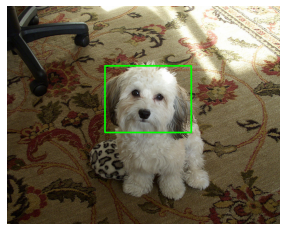

In [10]:
file = np.random.choice(os.listdir('annotations/xmls/'))
print(file)
drawBB(file)

### **Preprocessing Image**

In [11]:
## Generator function - generates the batches of image with some processing
def image_generator(files, batch_size = 32, sz = (256, 256)):
  
  while True: 
    
    #extract a random batch 
    batch = np.random.choice(files, size = batch_size)    
    
    #variables for collecting batches of inputs and outputs 
    batch_x = []
    batch_y = []
    
    ## iterating over image in randomly selected batch
    for f in batch:
        img_path = f'data/images/{f[:-4]}.jpg'
        img = Image.open(img_path)
        w,h = img.size
        
        img = img.resize(sz)

        ## getting the box coordinated
        (xmin, ymin), (xmax, ymax) = getBB(f)
        
        img = np.array(img).astype('float32')
        if len(img.shape) == 2:
          img = np.stack((img,)*3, axis=-1)

        else:
          img = img[:,:,0:3]
        
        box = np.array([xmin/w, ymin/h, xmax/w, ymax/h])

        batch_x.append(img/255)
        batch_y.append(box)

    #preprocess a batch of images and masks 
    batch_x = np.array(batch_x)
    batch_y = np.array(batch_y)

    yield (batch_x, batch_y)      
    

### **Creating train and test generators**

In [12]:
## Choosing batch size=32 and img_resizing to 256
batch_size = 32
IMG_SIZE = 256

all_files = os.listdir('annotations/xmls/')
shuffle(all_files)

split = int(0.95 * len(all_files))

#split into training and testing
train_files = all_files[0:split]
test_files  = all_files[split:]

print('Size of training ', len(train_files))
print('Size of testing  ', len(test_files))
train_generator = image_generator(train_files, batch_size = batch_size, sz = (IMG_SIZE, IMG_SIZE ))
test_generator  = image_generator(test_files, batch_size = batch_size, sz = (IMG_SIZE, IMG_SIZE ))

Size of training  3501
Size of testing   185


In [13]:
x, y = next(test_generator)

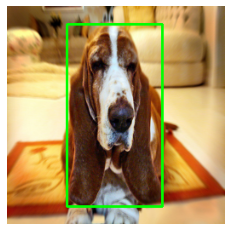

In [14]:
## Multiplying img to 255 becuase while creating generators divided by 255 for preprocessing image
## Here we need to display hence multiplyign again
img = (x[0] * 255).astype('uint8')

## box coordinates
box = y[0]
## multiplying coordinates by Image size becuase we took ratio while making generators
box = [int(IMG_SIZE *i) for i in box]

annotated = cv2.rectangle(img, (box[0], box[1]), (box[2], box[3]), (0,255,0), 2)
plt.axis('off')
plt.imshow(annotated)

### **Evaluation Metric**

#### Intersection over union is the metric choosen.
More information can be found -: https://www.pyimagesearch.com/2016/11/07/intersection-over-union-iou-for-object-detection/

In [2]:
def iou(boxA, boxB):
  
  #evaluate the intersection points 
  xA = tf.maximum(boxA[:, 0], boxB[:, 0])
  yA = tf.maximum(boxA[:, 1], boxB[:, 1])

  xB = tf.minimum(boxA[:, 2], boxB[:, 2])
  yB = tf.minimum(boxA[:, 3], boxB[:, 3])

  a1 = tf.maximum(0.0, xB - xA + 1)
  a2 = tf.maximum(0.0, yB - yA + 1)
  # compute the area of intersection rectangle
  interArea = a1 * a2

  # compute the area of both the prediction and ground-truth
  # rectangles
  boxAArea = (boxA[:, 2] - boxA[:, 0] + 1) * (boxA[:, 3] - boxA[:, 1] + 1)
  boxBArea = (boxB[:, 2] - boxB[:, 0] + 1) * (boxB[:, 3] - boxB[:, 1] + 1)

  unionArea = (boxAArea + boxBArea - interArea)

  # return the intersection over union value
  return tf.reduce_mean(interArea / unionArea)

### **Building Model**

In [18]:
inp = Input(shape = (IMG_SIZE, IMG_SIZE, 3))
conv1 = Conv2D(16, (3, 3), padding = 'same', activation = 'relu')(inp)
pool1 = MaxPooling2D(pool_size = (2, 2))(conv1)

conv2 = Conv2D(32, (3, 3), padding = 'same', activation = 'relu')(pool1)
pool2 = MaxPooling2D(pool_size = (2, 2))(conv2)

conv3 = Conv2D(64, (3, 3), padding = 'same', activation = 'relu')(pool2)
pool3 = MaxPooling2D(pool_size = (2, 2))(conv3)

conv4 = Conv2D(128, (3, 3), padding = 'same', activation = 'relu')(pool3)
pool4 = MaxPooling2D(pool_size = (2, 2))(conv4)

conv5 = Conv2D(256, (3, 3), padding = 'same', activation = 'relu')(pool4)
pool5 = MaxPooling2D(pool_size = (2, 2))(conv5)

conv6 = Conv2D(512, (3, 3), padding = 'same', activation = 'relu')(pool5)
pool6 = MaxPooling2D(pool_size = (2, 2))(conv6)

flatten = Flatten()(pool6)
dense1 = Dense(128, activation = 'relu')(flatten)
drop1  = Dropout(0.5)(dense1)
out = Dense(4, activation = 'sigmoid')(drop1)

model = tf.keras.models.Model(inputs = inp, outputs = out)
model.compile(optimizer=optimizers.Adam() , loss = 'mean_squared_error', metrics = [iou])

print(inp)
#create a checkpoint for the best model 
# model_save = ModelCheckpoint('best_model.h5', save_best_only=True, monitor='val_iou', mode='max', save_weights_only= True, verbose = 0)

Tensor("input_2:0", shape=(None, 256, 256, 3), dtype=float32)


In [19]:
train_steps = len(train_files) //batch_size
test_steps = len(test_files) //batch_size

model.fit_generator(train_generator, 
                    epochs = 30, steps_per_epoch = train_steps,validation_data = test_generator, validation_steps = test_steps)
                    # ,callbacks=[model_save])

Instructions for updating:
Please use Model.fit, which supports generators.
Epoch 1/30
Tensor("Maximum:0", shape=(None,), dtype=float32) Tensor("Maximum_1:0", shape=(None,), dtype=float32)
Tensor("Minimum:0", shape=(None,), dtype=float32) Tensor("Minimum_1:0", shape=(None,), dtype=float32)
Tensor("Maximum:0", shape=(None,), dtype=float32) Tensor("Maximum_1:0", shape=(None,), dtype=float32)
Tensor("Minimum:0", shape=(None,), dtype=float32) Tensor("Minimum_1:0", shape=(None,), dtype=float32)
109/109 [==============================] - ETA: 0s - loss: 0.0254 - iou: 0.7111Tensor("Maximum:0", shape=(None,), dtype=float32) Tensor("Maximum_1:0", shape=(None,), dtype=float32)
Tensor("Minimum:0", shape=(None,), dtype=float32) Tensor("Minimum_1:0", shape=(None,), dtype=float32)
109/109 [==============================] - 28s 261ms/step - loss: 0.0254 - iou: 0.7111 - val_loss: 0.0200 - val_iou: 0.7325
Epoch 2/30
109/109 [==============================] - 28s 258ms/step - loss: 0.0237 - iou: 0.7198 

In [21]:
model.save('localisation.h5')

### **Prediction**

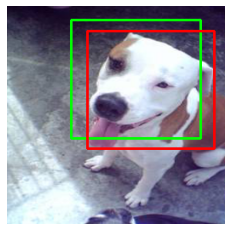

In [20]:
x,y = next(test_generator)
img = x[0]
box = model.predict(np.expand_dims(img, 0))[0]
box = [int(IMG_SIZE*i) for i in box]
annotated = cv2.rectangle((img*255) , (box[0], box[1]), (box[2], box[3]), (0, 255, 0), 2)
box = [int(IMG_SIZE * i) for i in y[0]]
annotated = cv2.rectangle((annotated) , (box[0], box[1]), (box[2], box[3]), (255, 0, 0), 2)

plt.axis('off')
plt.imshow((annotated ).astype('uint8'))

### **Unused Block**

In [ ]:
# os.mkdir("xmls")
# !mv annotations/xmls/* xmls/
# rm -r xmls
# import csv
# import cv2
# import glob
# import os
# import xml.etree.ElementTree as ET
# import numpy as np
# import csv
# import math

# from PIL import Image
# import numpy as np
# from tensorflow.keras import Model
# from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2, preprocess_input
# from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
# from tensorflow.keras.layers import Conv2D, Reshape
# from tensorflow.keras.utils import Sequence
# from tensorflow.keras.backend import epsilon
# DATASET_FOLDER = "xmls/"
# TRAIN_OUTPUT_FILE = "train.csv"
# VALIDATION_OUTPUT_FILE = "validation.csv"

# SPLIT_RATIO = 0.8

# def main():
#     if not os.path.exists(DATASET_FOLDER):
#         print("Dataset not found")
#         return

#     class_names = {}
#     k = 0
#     output = []
#     xml_files = glob.glob("{}/*xml".format(DATASET_FOLDER))
#     for i, xml_file in enumerate(xml_files):
#         tree = ET.parse(xml_file)

#         path = os.path.join(DATASET_FOLDER, tree.findtext("./filename"))

#         height = int(tree.findtext("./size/height"))
#         width = int(tree.findtext("./size/width"))
#         xmin = int(tree.findtext("./object/bndbox/xmin"))
#         ymin = int(tree.findtext("./object/bndbox/ymin"))
#         xmax = int(tree.findtext("./object/bndbox/xmax"))
#         ymax = int(tree.findtext("./object/bndbox/ymax"))

#         basename = os.path.basename(path)
#         basename = os.path.splitext(basename)[0]
#         class_name = basename[:basename.rfind("_")].lower()
#         if class_name not in class_names:
#             class_names[class_name] = k
#             k += 1

#         output.append((path, height, width, xmin, ymin, xmax, ymax, class_name, class_names[class_name]))

#     # preserve percentage of samples for each class ("stratified")
#     output.sort(key=lambda tup : tup[-1])

#     lengths = []
#     i = 0
#     last = 0
#     for j, row in enumerate(output):
#         if last == row[-1]:
#             i += 1
#         else:
#             print("class {}: {} images".format(output[j-1][-2], i))
#             lengths.append(i)
#             i = 1
#             last += 1

#     print("class {}: {} images".format(output[j-1][-2], i))
#     lengths.append(i)

#     with open(TRAIN_OUTPUT_FILE, "w") as train, open(VALIDATION_OUTPUT_FILE, "w") as validate:
#         writer = csv.writer(train, delimiter=",")
#         writer2 = csv.writer(validate, delimiter=",")

#         s = 0
#         for c in lengths:
#             for i in range(c):
#                 print("{}/{}".format(s + 1, sum(lengths)), end="\r")

#                 path, height, width, xmin, ymin, xmax, ymax, class_name, class_id = output[s]

#                 if xmin >= xmax or ymin >= ymax or xmax > width or ymax > height or xmin < 0 or ymin < 0:
#                     print("Warning: {} contains invalid box. Skipped...".format(path))
#                     continue

#                 row = [path, height, width, xmin, ymin, xmax, ymax, class_name, class_names[class_name]]
#                 if i <= c * SPLIT_RATIO:
#                     writer.writerow(row)
#                 else:
#                     writer2.writerow(row)

#                 s += 1

#     print("\nDone!")

#     """ preprocess_input is as good as exact mean/std
#     print("Calculating mean and std...")
#     mean = 0
#     std = 0
#     length = 0
#     images = glob.glob("{}/*".format(TRAIN_FOLDER))
#     for i, path in enumerate(images):
#         print("{}/{}".format(i + 1, len(images)), end="\r")
#         sum_ = np.mean(cv2.imread(path))
#         length += 1
#         mean_next = mean + (sum_ - mean) / length
#         std += (sum_ - mean) * (sum_ - mean_next)
#         mean = mean_next
#     std = np.sqrt(std / (length - 1))
#     print("\nMean: {}".format(mean))
#     print("Std: {}".format(std))
#     """


# # if __name__ == "__main__":
# main()
# # 0.35, 0.5, 0.75, 1.0
# ALPHA = 1.0

# # 96, 128, 160, 192, 224
# IMAGE_SIZE = 96

# EPOCHS = 2
# BATCH_SIZE = 32
# PATIENCE = 50

# MULTI_PROCESSING = False
# THREADS = 1

# TRAIN_CSV = "train.csv"
# VALIDATION_CSV = "validation.csv"


# class DataGenerator(Sequence):

#     def __init__(self, csv_file):
#         self.paths = []

#         with open(csv_file, "r") as file:
#             self.coords = np.zeros((sum(1 for line in file), 4))
#             file.seek(0)

#             reader = csv.reader(file, delimiter=",")
#             for index, row in enumerate(reader):
#                 for i, r in enumerate(row[1:7]):
#                     row[i+1] = int(r)

#                 path, image_height, image_width, x0, y0, x1, y1, _, _ = row
#                 self.coords[index, 0] = x0 * IMAGE_SIZE / image_width
#                 self.coords[index, 1] = y0 * IMAGE_SIZE / image_height
#                 self.coords[index, 2] = (x1 - x0) * IMAGE_SIZE / image_width
#                 self.coords[index, 3] = (y1 - y0) * IMAGE_SIZE / image_height 

#                 self.paths.append(path)

#     def __len__(self):
#         return math.ceil(len(self.coords) / BATCH_SIZE)

#     def __getitem__(self, idx):
#         batch_paths = self.paths[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE]
#         batch_coords = self.coords[idx * BATCH_SIZE:(idx + 1) * BATCH_SIZE]

#         batch_images = np.zeros((len(batch_paths), IMAGE_SIZE, IMAGE_SIZE, 3), dtype=np.float32)
#         for i, f in enumerate(batch_paths):
#             img = Image.open(f)
#             img = img.resize((IMAGE_SIZE, IMAGE_SIZE))
#             img = img.convert('RGB')

#             batch_images[i] = preprocess_input(np.array(img, dtype=np.float32))
#             img.close()

#         return batch_images, batch_coords

# class Validation(Callback):
#     def __init__(self, generator):
#         self.generator = generator

#     def on_epoch_end(self, epoch, logs):
#         mse = 0
#         intersections = 0
#         unions = 0

#         for i in range(len(self.generator)):
#             batch_images, gt = self.generator[i]
#             pred = self.model.predict_on_batch(batch_images)
#             mse += np.linalg.norm(gt - pred, ord='fro') / pred.shape[0]

#             pred = np.maximum(pred, 0)

#             diff_width = np.minimum(gt[:,0] + gt[:,2], pred[:,0] + pred[:,2]) - np.maximum(gt[:,0], pred[:,0])
#             diff_height = np.minimum(gt[:,1] + gt[:,3], pred[:,1] + pred[:,3]) - np.maximum(gt[:,1], pred[:,1])
#             intersection = np.maximum(diff_width, 0) * np.maximum(diff_height, 0)

#             area_gt = gt[:,2] * gt[:,3]
#             area_pred = pred[:,2] * pred[:,3]
#             union = np.maximum(area_gt + area_pred - intersection, 0)

#             intersections += np.sum(intersection * (union > 0))
#             unions += np.sum(union)

#         iou = np.round(intersections / (unions + epsilon()), 4)
#         logs["val_iou"] = iou

#         mse = np.round(mse, 4)
#         logs["val_mse"] = mse

#         print(" - val_iou: {} - val_mse: {}".format(iou, mse))

# def create_model(trainable=False):
#     model = MobileNetV2(input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3), include_top=False, alpha=ALPHA)

#     # to freeze layers
#     for layer in model.layers:
#         layer.trainable = trainable

#     x = model.layers[-1].output
#     x = Conv2D(4, kernel_size=3, name="coords")(x)
#     x = Reshape((4,))(x)

#     return Model(inputs=model.input, outputs=x)

# def main():
#     model = create_model()
#     model.summary()

#     train_datagen = DataGenerator(TRAIN_CSV)
#     validation_datagen = Validation(generator=DataGenerator(VALIDATION_CSV))

#     model.compile(loss="mean_squared_error", optimizer="adam", metrics=[])

#     # checkpoint = ModelCheckpoint("model-1.h5", monitor="val_iou", verbose=1, save_best_only=True,
#     #                              save_weights_only=True, mode="max")
#     # stop = EarlyStopping(monitor="val_iou", patience=PATIENCE, mode="max")
#     # reduce_lr = ReduceLROnPlateau(monitor="val_iou", factor=0.2, patience=10, min_lr=1e-7, verbose=1, mode="max")

#     model.fit_generator(generator=train_datagen,
#                         epochs=EPOCHS,
#                         # callbacks=[validation_datagen, checkpoint, reduce_lr, stop],
#                         workers=THREADS,
#                         use_multiprocessing=MULTI_PROCESSING,
#                         shuffle=True,
#                         verbose=1)

#     model.save("localisation.h5")
# main()

NameError: ignored